# Text Analysis and Visualisation

[Simone Lombardini](https://sites.google.com/view/simone-lombardini/home-page) - 23 June 2020

This notebook use data from the [Effectiveness Review in Jordan](https://policy-practice.oxfam.org.uk/publications/livelihoods-in-the-zaatari-camp-impact-evaluation-of-oxfams-cash-for-work-activ-620883) to explore how to perform some basic text analysis on short open ended questions and data visualization using the `seaborn` library. 

In [129]:
# basic
import os
import pandas as pd
import numpy as np    
import datetime as dt

# graphs
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
# Set graphic parameters
sns.set(style="darkgrid", context="paper")

# text analysis
import string 
import re 
import nltk
import regex

from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize
from nltk.corpus import stopwords

from textblob import TextBlob

# word clouds
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

# word frequency
from collections import Counter

In [130]:
df = pd.read_stata('npl_jordan.dta')

In [131]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1405 entries, 0 to 1404
Data columns (total 8 columns):
seekingx        1350 non-null float32
seekingy        1350 non-null float32
outcome         1329 non-null float32
recomend        1325 non-null float32
workwhat        1405 non-null object
workwhere       1405 non-null object
workyn          1405 non-null object
openquestion    1405 non-null object
dtypes: float32(4), object(4)
memory usage: 76.8+ KB


In [132]:
df.head()

,seekingx,seekingy,outcome,recomend,workwhat,workwhere,workyn,openquestion
0,0.140083,0.094898,0.39,0.76,Work_Paid_NotCFW,Work Inside,No,"since arriving, no job depite extensive search..."
1,0.356449,0.325931,0.06,0.95,Work_CFW_Ox,Work Inside,Yes,since I came in 2013 I was depressed and despe...
2,0.532594,0.181710,0.14,0.92,Work_Paid_NotCFW,Work Inside,No,Ahmad arrived 5 years ago and started looking ...
3,0.231623,0.047291,0.06,0.93,Work_CFW_Ox,Work Inside,Yes,I came to Jordan and then got married and star...
4,0.500694,0.244718,0.23,1.00,Work_CFW_Ox,Work Inside,Yes,I worked with Oxfam as a raising awareness and...


The variables of interest are:
* **openquestion** This is an open text field. The question was `Can you share an example of trying to access paid work since you arrived in the camp?` 
* **workwhat** This is a multiple-choice question. It asked the repondent to specify if the story is about: `Cash for work (with Oxfam)`, `Cash for work (with other agency)`, `Other work paid in money (not CFW)`, `Other work paid in exchange of goods (e.g. food, equipment, etc.)`, `Other work paid in exchange of services (e.g. childcare, trading skills, helping out, etc.)`, `Other work`
* **workwhere** A multiple-choice question to specify if the work was outside or inside the camp. 
* **workyn** A multiple-choice quesiton to specify if the respondent did you carry out this work (even if it was temporaty)
* **outcome** This question is asking from a value to zero to 100 to which extent the respondent achieved the outcome they were trying to achieve in their story. Where 0 is `entirely` and 100 is `not at all`
* **recomend** This quesiton is asking from a value to zero to 100 if the respondent would recommend to other friends in this situation to pursue similar work to the one in your story? Where 0 is `not at all` and 100 is `entirealy`

## Text analysis

In [133]:
df.openquestion.head()

0    since arriving, no job depite extensive search...
1    since I came in 2013 I was depressed and despe...
2    Ahmad arrived 5 years ago and started looking ...
3    I came to Jordan and then got married and star...
4    I worked with Oxfam as a raising awareness and...
Name: openquestion, dtype: object

### Word counts

In [134]:
text = " ".join(msg for msg in df.openquestion)
print ("There are total of {} words in the 1405 responses.".format(len(text)))

There are total of 318852 words in the 1405 responses.


### Cleaning

In [135]:
stop_words_ = set(stopwords.words('english'))
wn = WordNetLemmatizer()

my_sw = ['Ahmad', 'omit']
def black_txt(token):
    return  token not in stop_words_ and token not in list(string.punctuation)  and len(token)>2 and token not in my_sw
  
def clean_txt(text):
  clean_text = []
  clean_text2 = []
  text = re.sub("'", "",text)
  text = re.sub("(\\d|\\W)+"," ",text)
  text = re.sub(r'[^\x00-\x7f]',r'', text) 
  clean_text = [ wn.lemmatize(word, pos="v") for word in word_tokenize(text.lower()) if black_txt(word)]
  clean_text2 = [word for word in clean_text if black_txt(word)]
  return " ".join(clean_text2)

In [136]:
cleantext = clean_txt(text)
print("There are a total of {} words in all 1405 responses after cleaning.".format(len(cleantext)))

There are a total of 111775 words in all 1405 responses after cleaning.


Let's see an example of what it means to clean a response

In [137]:
df.openquestion[10]

'we came to Jordan and I started looking for a job until I worked with an organisation in water distribution. I worked for w while and the income was ok because I nee to fulfil the family needs. they fired me and I started looking for other jobs'

In [138]:
clean_txt(df.openquestion[10])

'come jordan start look job work organisation water distribution work income nee fulfil family need fire start look job'

### Word frequency
What are the 10 most frequently used words?

In [139]:
# split() returns list of all the words in the string 
split_it = cleantext.split() 
  
# Pass the split_it list to instance of Counter class. 
CounterVar = Counter(split_it)
  
# most_common() produces k frequently encountered 
# input values and their respective counts. 
most_occur = CounterVar.most_common(10) 
  
print (f"The 10 most frequent words are: {most_occur}") 

The 10 most frequent words are: [('work', 1845), ('job', 469), ('oxfam', 440), ('good', 363), ('months', 347), ('experience', 346), ('camp', 334), ('income', 304), ('guard', 244), ('positive', 213)]


#### Word frequency by `workyn`
Are these words different on whether the respondend did carry out the work in the end? (variable `workyn`)

In [140]:
def mostfrequword (var, val):
    df2 = df[df[var]==val]
    text2 = " ".join(msg for msg in df2.openquestion)
    cleantext2 = clean_txt(text2)
    split_it2 = cleantext2.split()
    CounterVars2 = Counter(split_it2)
    most_occur_5 = CounterVars2.most_common(5) 
    print(f"For {val} the most frequent words is {most_occur_5}")

In [141]:
mostfrequword('workyn', 'Yes')
mostfrequword('workyn', 'No')

For Yes the most frequent words is [('work', 1499), ('oxfam', 352), ('job', 346), ('good', 305), ('months', 287)]
For No the most frequent words is [('work', 346), ('job', 123), ('experience', 96), ('oxfam', 88), ('apply', 75)]


### Word counts

In [142]:
df['word_count'] = df.openquestion.apply(len) 

## Sentiment analysis

Let's do some sentiment analysis computing Polarity and Subjectivity.
* The polarity score is a float within the range (-1.0, 1.0), with negative values associated with more negative words, and positive values associated with positive words.
* The subjectivity score is a float with range (0.0, 1.0), with 0 being very objective and 1 very subjective

In [143]:
def evaluate_polarity(text):
  return TextBlob(text).sentiment[0]

def evaluate_subjectivity(text):
  return  TextBlob(text).sentiment[1]

In [144]:
%%time
df['polarity'] = df.openquestion.apply(evaluate_polarity)
df['subjectivity'] = df.openquestion.apply(evaluate_subjectivity)

Wall time: 3.16 s


In [145]:
measures = ['polarity', 'subjectivity']
df[measures].describe()

,polarity,subjectivity
count,1405.000000,1405.000000
mean,0.088912,0.436152
std,0.290793,0.259845
min,-0.900000,0.000000
25%,-0.055556,0.295833
50%,0.000000,0.470833
75%,0.250000,0.600000
max,1.000000,1.000000


#### Polarity
Is the polarity score (use of positive or negative words) different whether the respondent obtained the job?

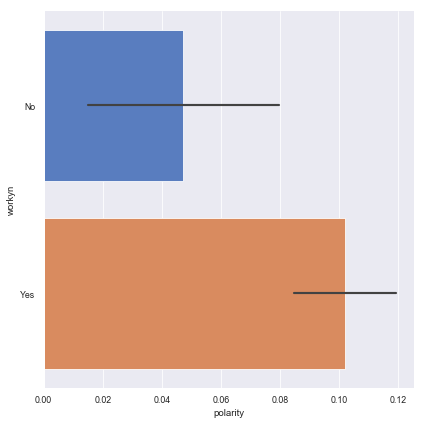

In [146]:
g = sns.catplot(x="polarity", y="workyn", data=df, height=6, kind="bar", palette="muted")

#### Subjectivity
Is the subjectivity score (objective or subjective sentences) different depending on the type of job?

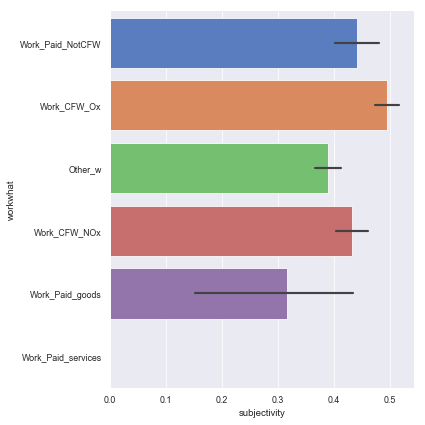

In [147]:
g = sns.catplot(x="subjectivity", y="workwhat", data=df, height=6, kind="bar", palette="muted")

### Word ratio

In [148]:
def compute_word_ratio(text):
  if len(text.split())>0:
         return len(set(clean_txt(text).split()))/ len(text.split())
  else:
         return 0

In [149]:
df['word_ratio'] = df.openquestion.apply(compute_word_ratio)

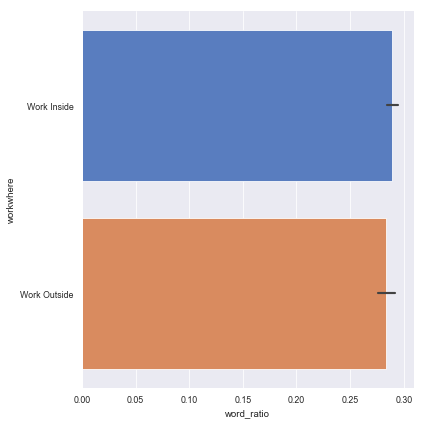

In [150]:
g = sns.catplot(x="word_ratio", y="workwhere", data=df, height=6, kind="bar", palette="muted")

## Visualization
### Word cloud

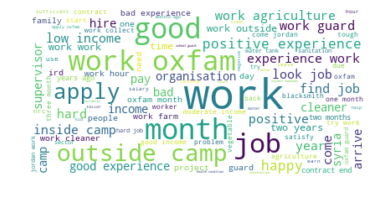

In [151]:
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(cleantext)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

**outcome** In your story, from a scale to 0 to 100, up to which extend did you achieve your objective? Where 0 is `entirely` and 100 `not at all`

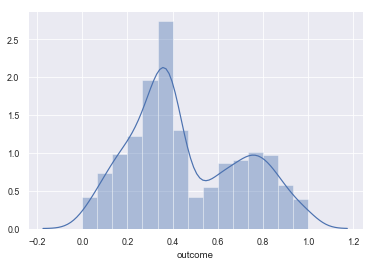

In [152]:
x = df.outcome.fillna(df.outcome.median())
sns.distplot(x)

Does this differ if the repondend obtained the job?

Text(0.5, 1.0, 'Outcome if carried out work')

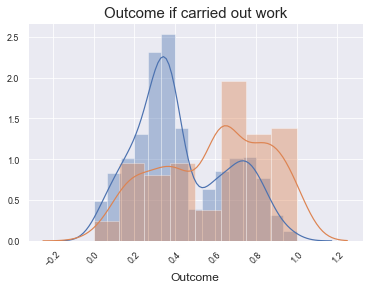

In [153]:
work_y = df[df['workyn']=='Yes']
x_1 = work_y.outcome.fillna(work_y.outcome.median())

work_n = df[df['workyn']=='No']
x_2 = work_n.outcome.fillna(work_n.outcome.median())

sns.distplot(x_1, label = 'Outcome if Work Yes')
sns.distplot(x_2, label = 'Outcome if Work No')


plt.xticks(rotation=45)
plt.xlabel("Outcome", fontsize= 12)
plt.title("Outcome if carried out work", fontsize= 15)

How are the variables `outcome` and `recomend` interconnected? 

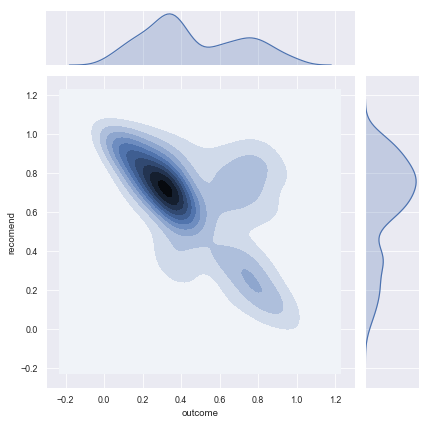

In [154]:
sns.jointplot(x="outcome", y="recomend", data=df, kind="kde");